# Assignment Four for Fall 2024 DATA 624: Preprocessing and Overfitting
#### Author: Kevin Kirby

This assignment consists of exercises 3.1 and 3.2 from [Applied Predictive Modeling](http://appliedpredictivemodeling.com/) by Max Kuhn and Kjell Johnson. Each question is as provided in the book and has the pandas library required for that section that aren't already imported. 

## 3.1. UC Irvine Machine Learning Repository Glass Identification Review

Information about the dataset [can be found here](https://archive.ics.uci.edu/dataset/42/glass+identification). I imported it using Python code provided by ICU. Per the exercise question, "the data consist of 214 glass samples labeled as one  of seven class categories. There are nine predictors, including the refractive  index and percentages of eight elements: Na, Mg, Al, Si, K, Ca, Ba, and Fe."

The exercise asks for the following:

A. Using visualizations, explore the predictor variables to understand their  distributions as well as the relationships between predictors.  
B. Do there appear to be any outliers in the data? Are any predictors skewed?  
C. Are there any relevant transformations of one or more predictors that  might improve the classification model? 

First, import and setup the data:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo
import ssl
from sklearn.impute import SimpleImputer
import numpy as np
from scipy.stats import boxcox
from sklearn.preprocessing import PowerTransformer


ssl._create_default_https_context = ssl._create_unverified_context
glass_identification = fetch_ucirepo(name='Glass Identification')

X = glass_identification.data.features 
y = glass_identification.data.targets 

### A. Exploratory data analysis through visualizations

This first part shows the following by predictor:
* Histograms
* Box plots
* Correlation matrix
* Pairplots



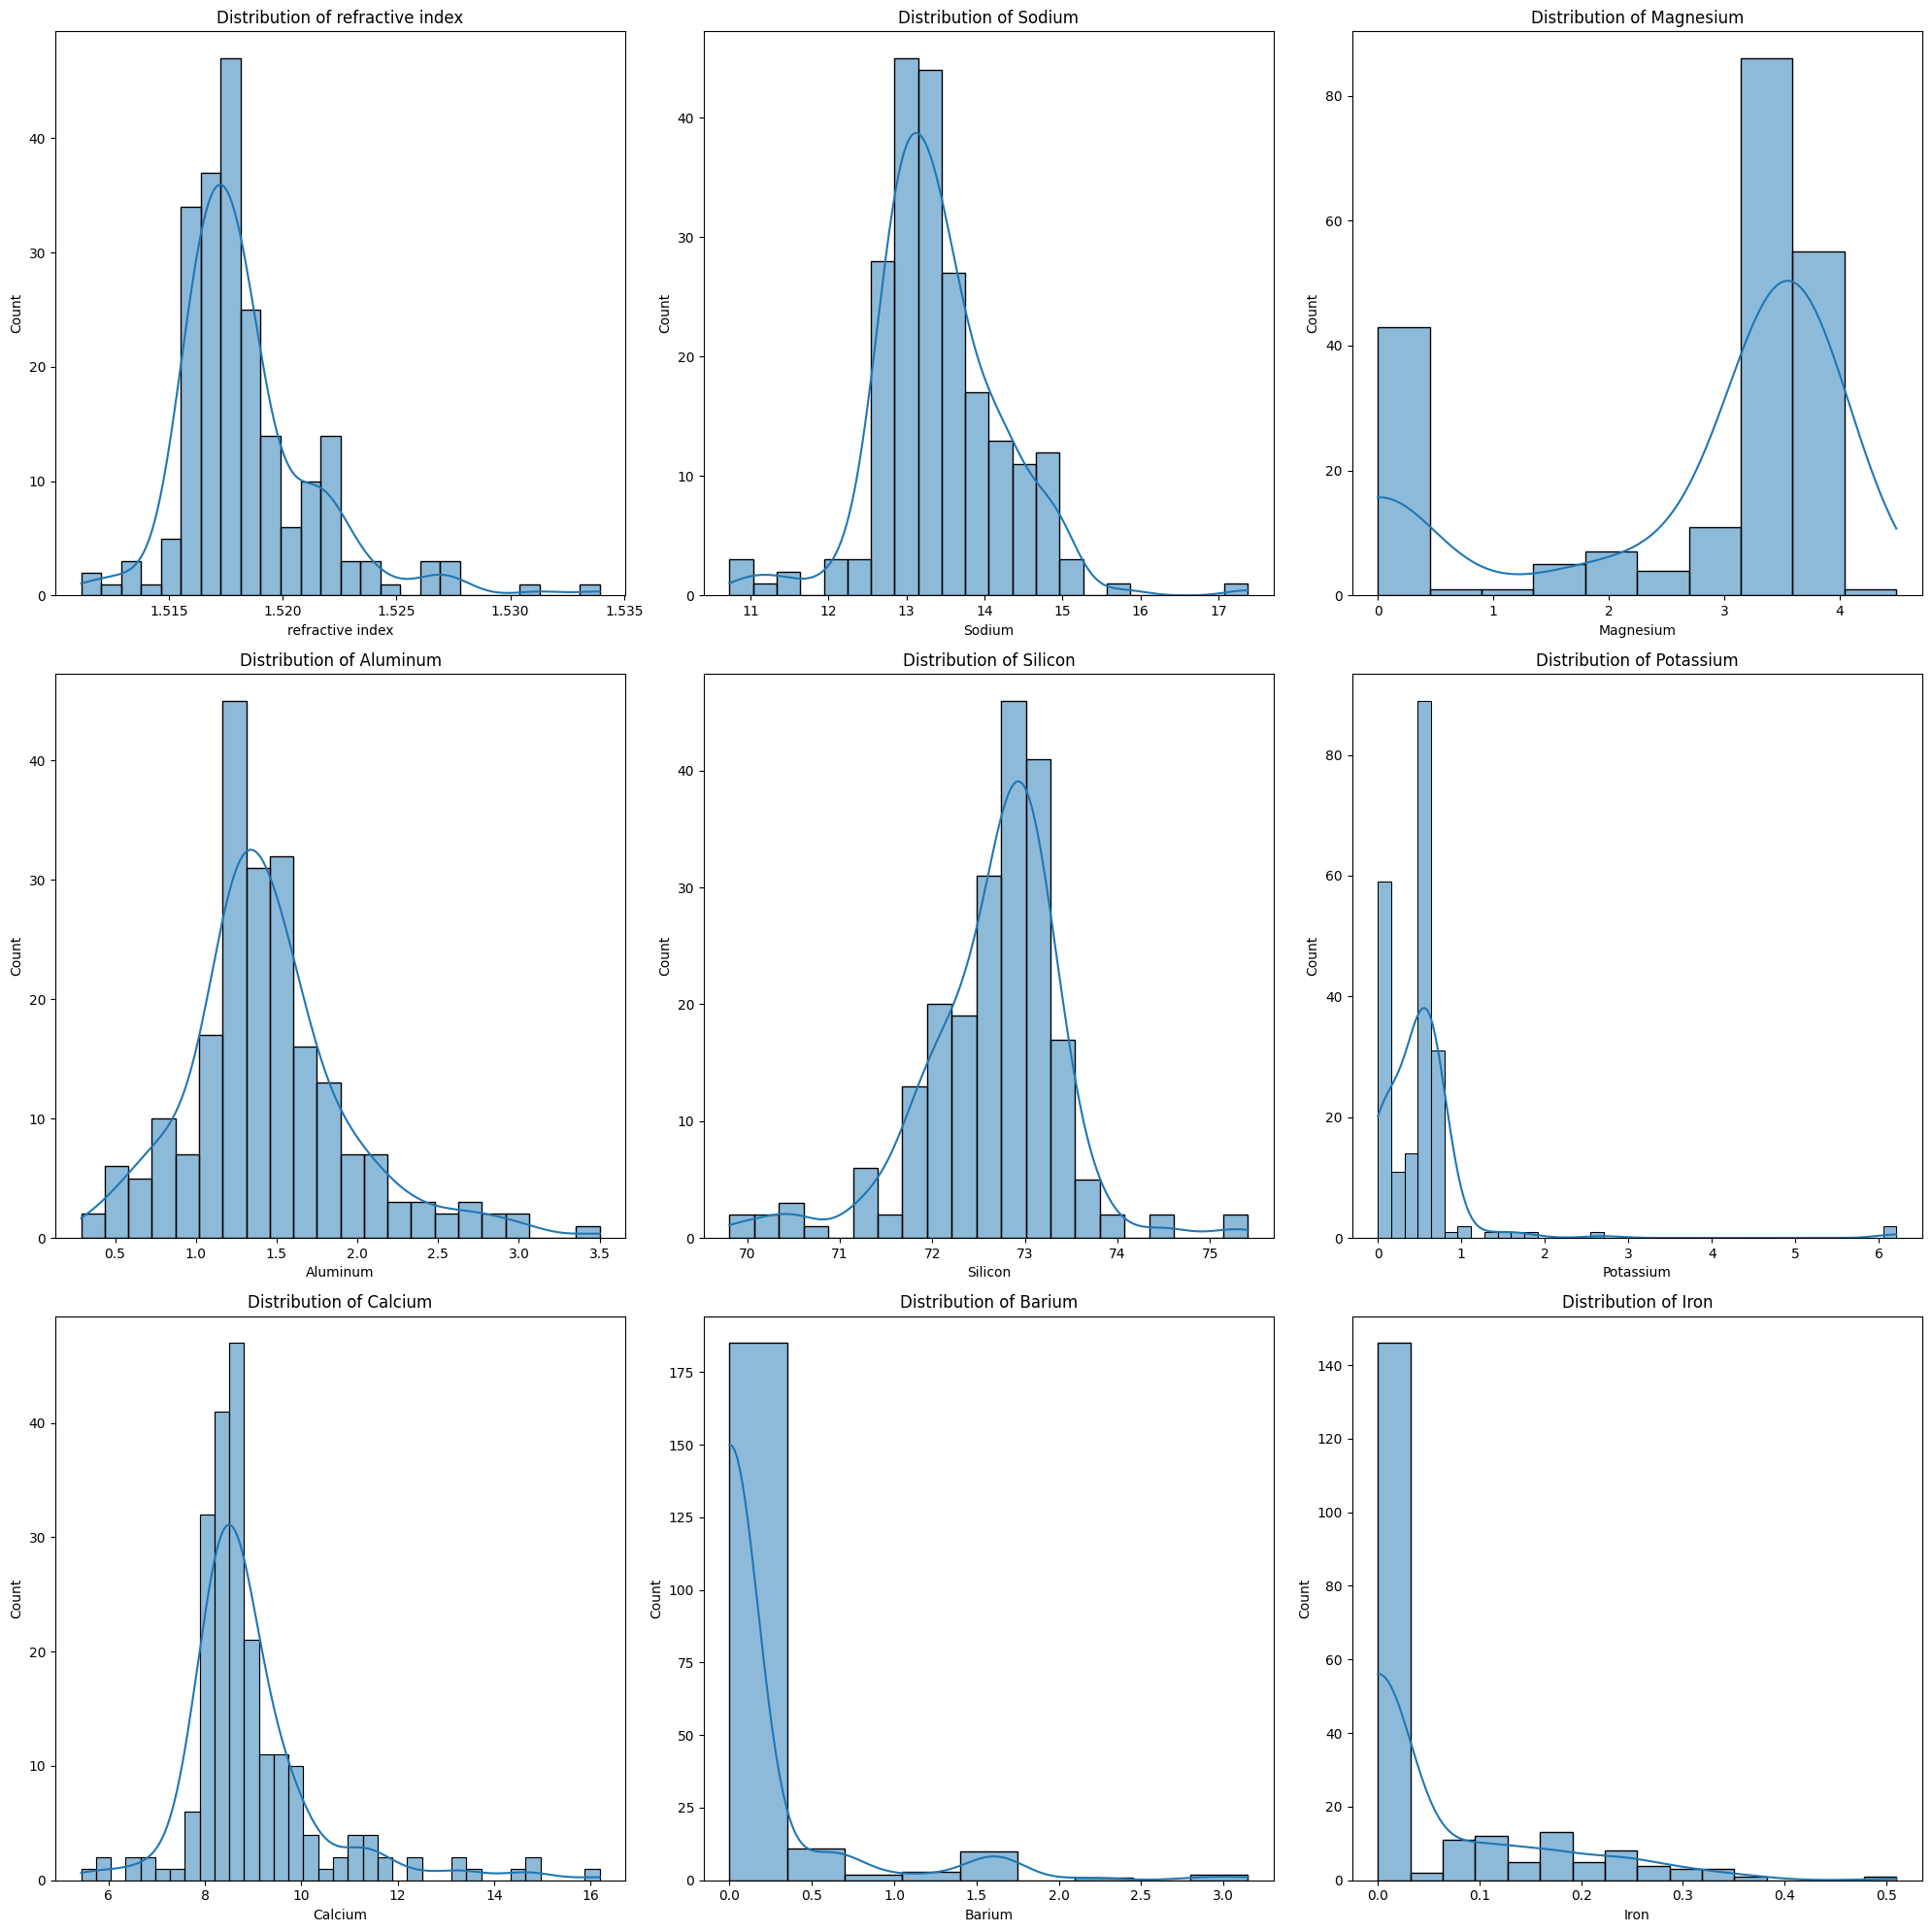

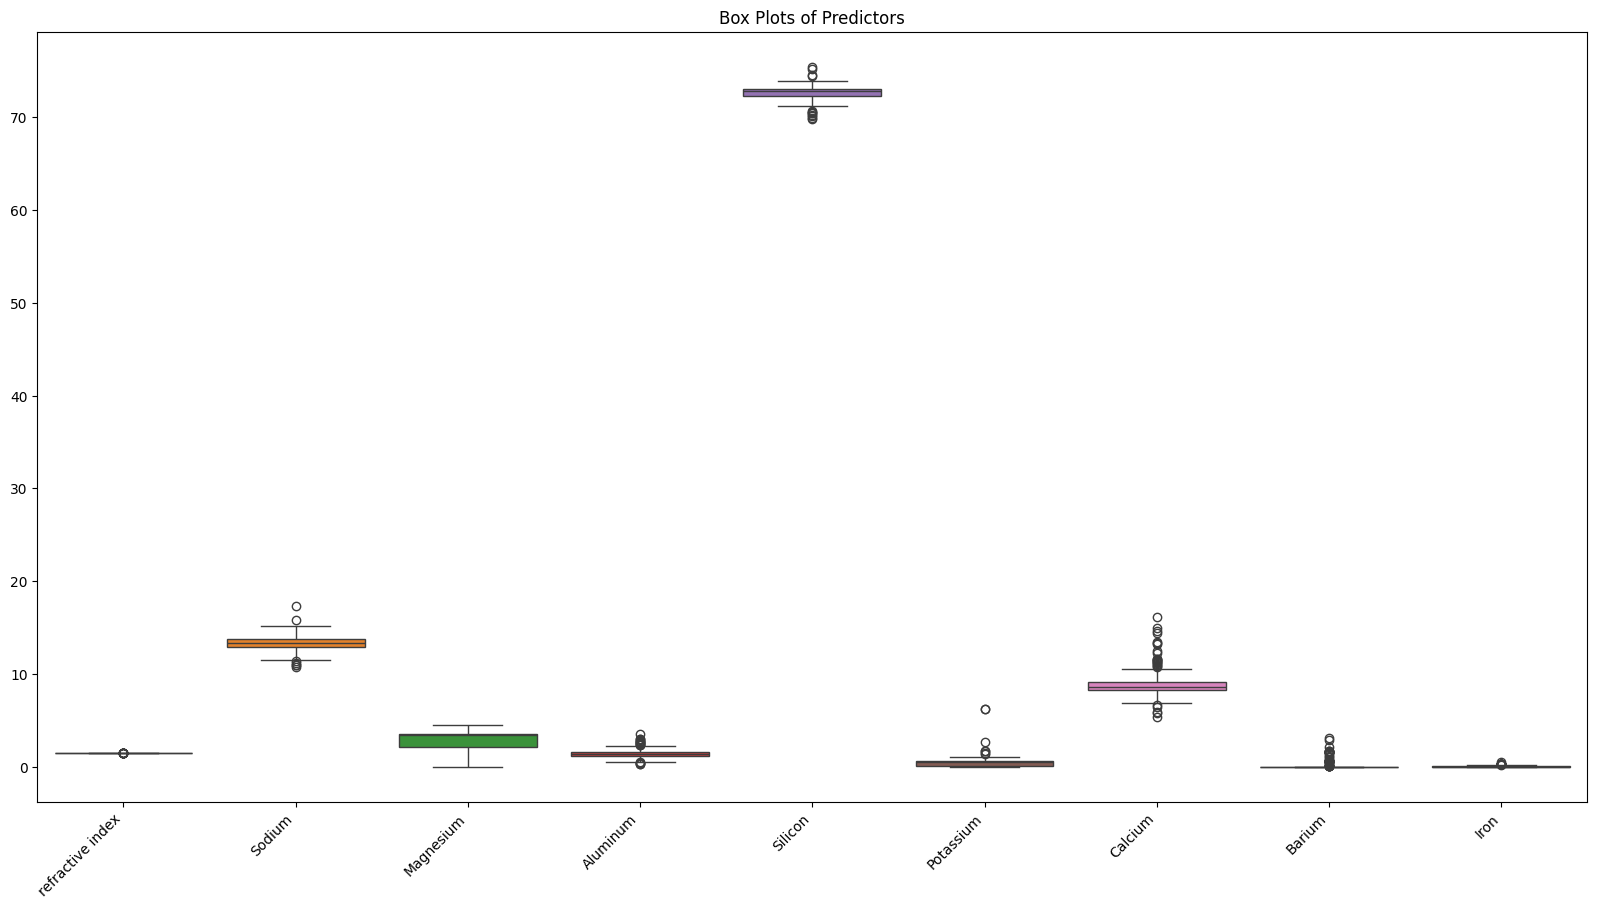

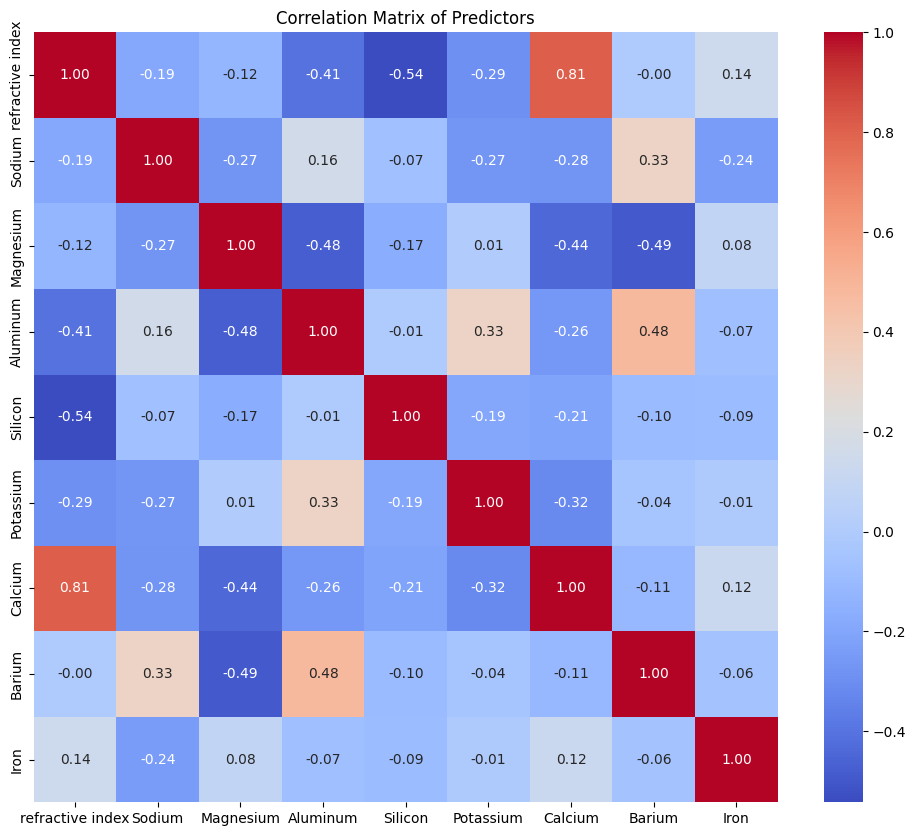

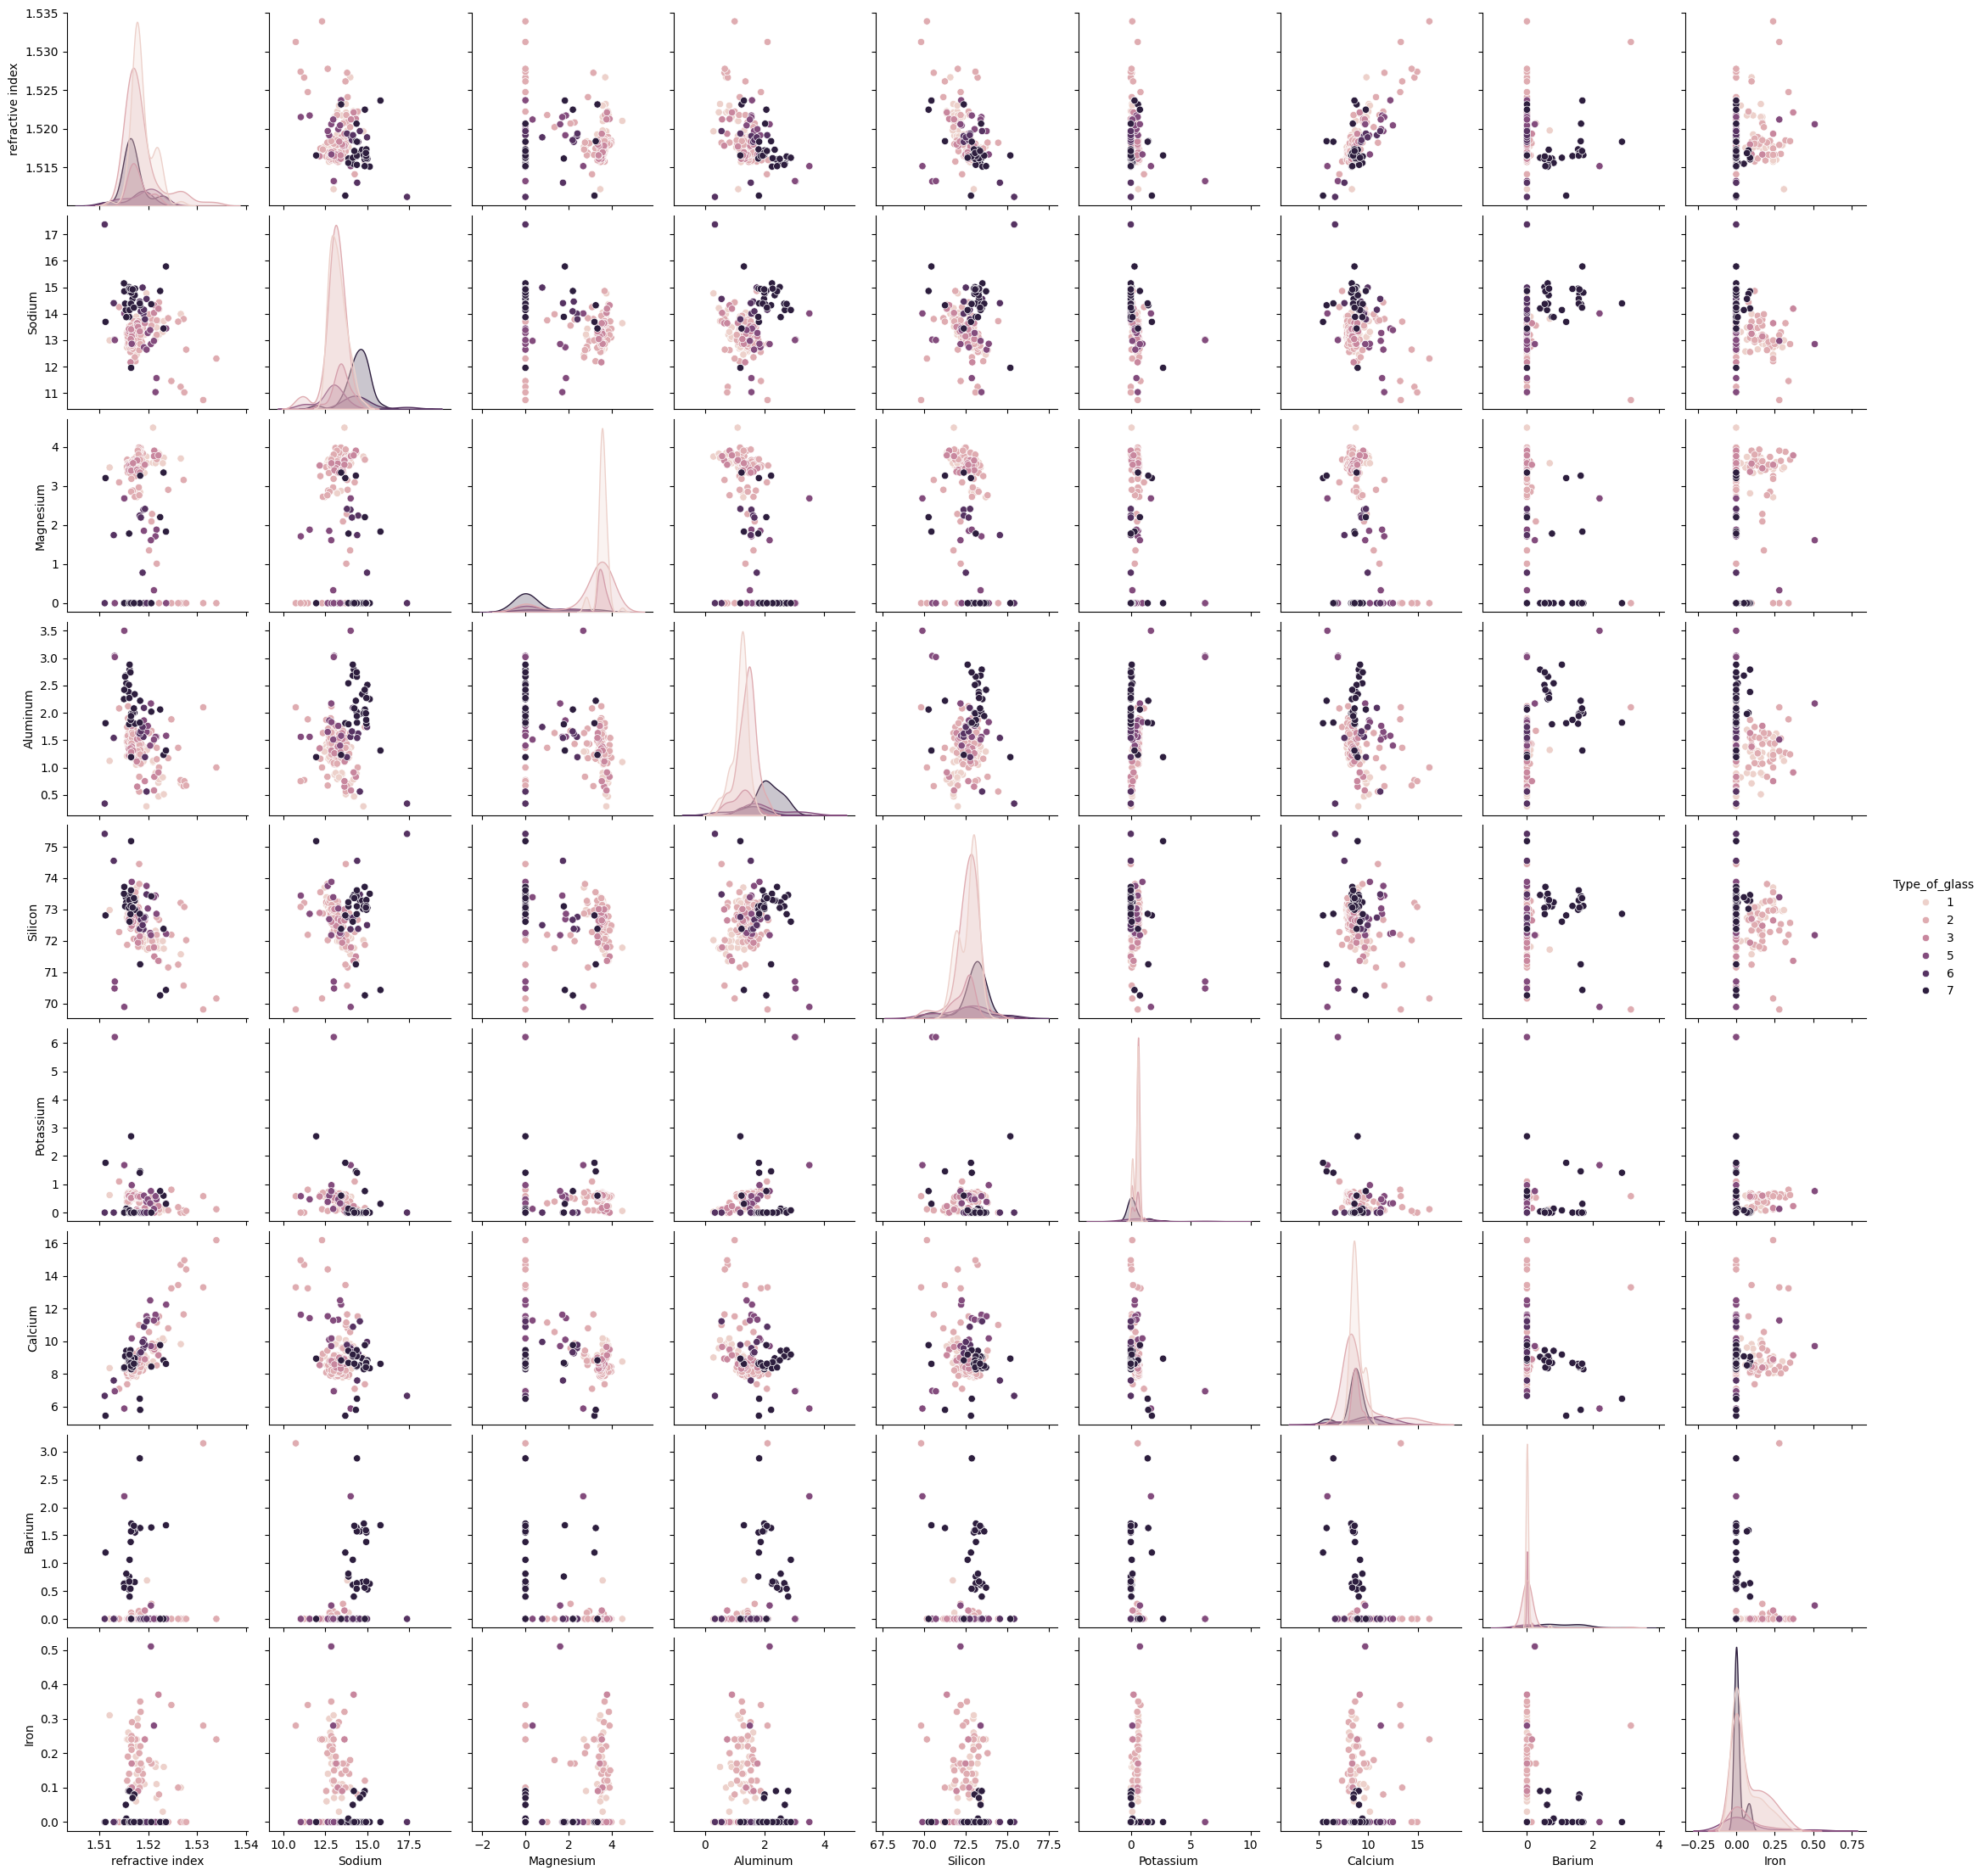

In [2]:
full_salts = {row['name']: row['description'] for _, row in glass_identification.variables.iterrows() if row['name'] in X.columns}

# Rename the columns of X
X = X.rename(columns=full_salts)
Glass = pd.concat([X, y], axis=1)


#histograms
plt.figure(figsize=(20, 20))
for i, column in enumerate(X.columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(X[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
plt.tight_layout()
plt.show()

#boxplots
plt.figure(figsize=(20, 10))
sns.boxplot(data=X)
plt.xticks(rotation=45, ha='right')
plt.title('Box Plots of Predictors')
plt.show()

# correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Predictors')
plt.show()

# pairplots
sns.pairplot(Glass, hue=y.columns[0])
plt.show()



### B. Do there appear to be any outliers in the data? Are any predictors skewed? 

Answer:
* Calcium and Refractivve Index have a strong negative relationship of -.81%
* Potasium, Barium, and Iron have strong right skews
* Silicon has the closest thing to a normal curve
    * Silicon is also causing heavy distortions in the box plot charts as its overall values are much higher than the others

### C. Are there any relevant transformations of one or more predictors that  might improve the classification model? 

Answer: I went with a box-cox transformation since we've learned a lot about it thus far. I chose it because I wanted to try and normalize the curves a bit and see if I could reduce some of the variance. It had the intended effect, to an extent. Sodium was brough down much closer to where the others had previous been. Refractive Index was exploded in a very weird way, though. going from a normalish curive to just a full colored box. 

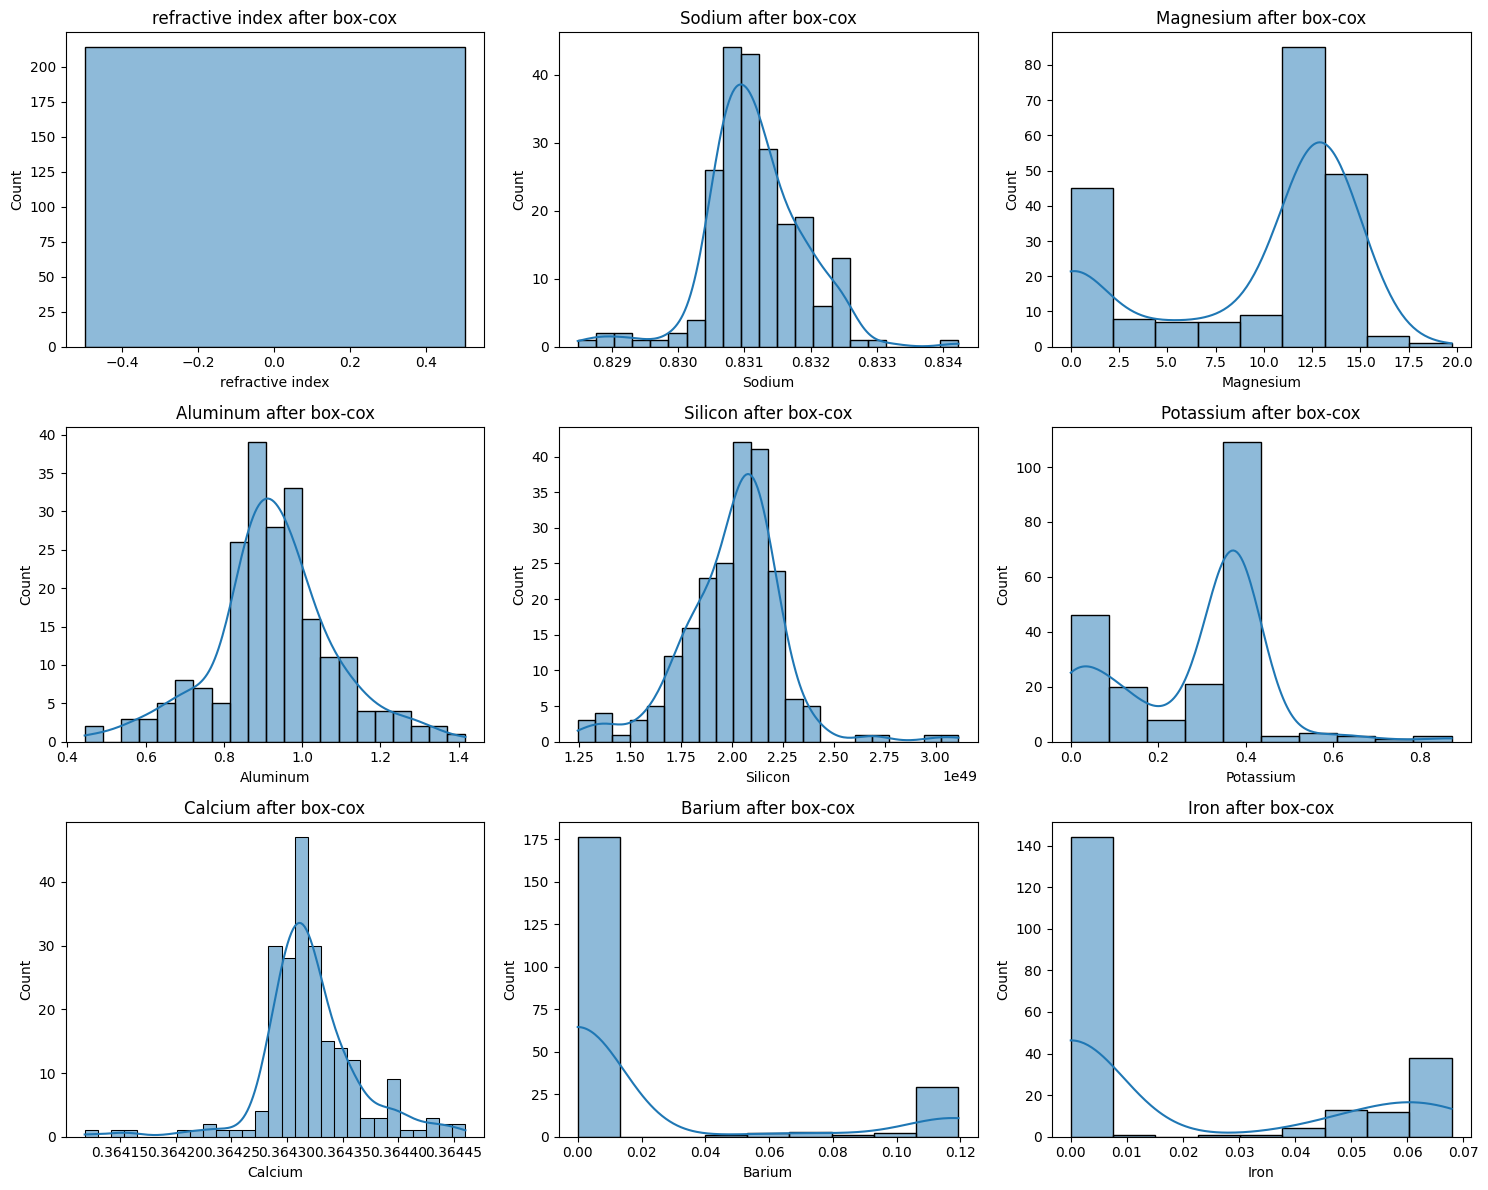

In [3]:
X_transformed = X.copy()

if (X_transformed <= 0).any().any():
    X_positive = X_transformed + np.abs(X_transformed.min()) + 1 
else:
    X_positive = X_transformed 

pt = PowerTransformer(method='box-cox', standardize=False)

X_boxcox = pd.DataFrame(pt.fit_transform(X_positive), columns=X.columns)
Glass_transformed = pd.concat([X_boxcox, y], axis=1)

plt.figure(figsize=(15, 12))
for i, column in enumerate(X_boxcox.columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(X_boxcox[column], kde=True)
    plt.title(f"{column} after box-cox")

plt.tight_layout()
plt.show()


## 3.2 - UC Irvine Machine Learning Repository Soyboy Dataset Review

This exercise is a series of data cleaning questions about the [Soybean(Large)](https://archive.ics.uci.edu/dataset/90/soybean+large) dataset from the UCIML. 

Per the exercise question from the book, "data were collected to predict disease in 683 soybeans. The 35  predictors are mostly categorical and include information on the environmental conditions (e.g., temperature, precipitation) and plant conditions (e.g., left  spots, mold growth). The outcome labels consist of 19 distinct classes."

The questions are:

A. Investigate the frequency distributions for the categorical predictors. Are  any of the distributions degenerate in the ways discussed earlier in this  chapter?  
B. Roughly 18% of the data are missing. Are there particular predictors that  are more likely to be missing? Is the pattern of missing data related to  the classes?  
C. Develop a strategy for handling missing data, either by eliminating  predictors or imputation. 

First, import and setup the data:

In [4]:

import math
from matplotlib.ticker import PercentFormatter
soybean_large = fetch_ucirepo(id=90) 
X = soybean_large.data.features 
y = soybean_large.data.targets 


### A. Investigate the frequency distributions for the categorical predictors

Are any of the distributions degenerate in the ways discussed earlier in this  chapter?  

Answer: More of these categorical predictors are degenerater than I would have initially guessed. For example, Leaf-Malf is very close to being a zero variance predictor, where almost all the values belong to 0 and hardly any to one. Mycelium and Sclerotia are in the same bucket. Compare this against Date, Crop-Hist, or Area-Damages each have healthy distributions across zero to three. This will make them easier to model since they have more data in different variety.

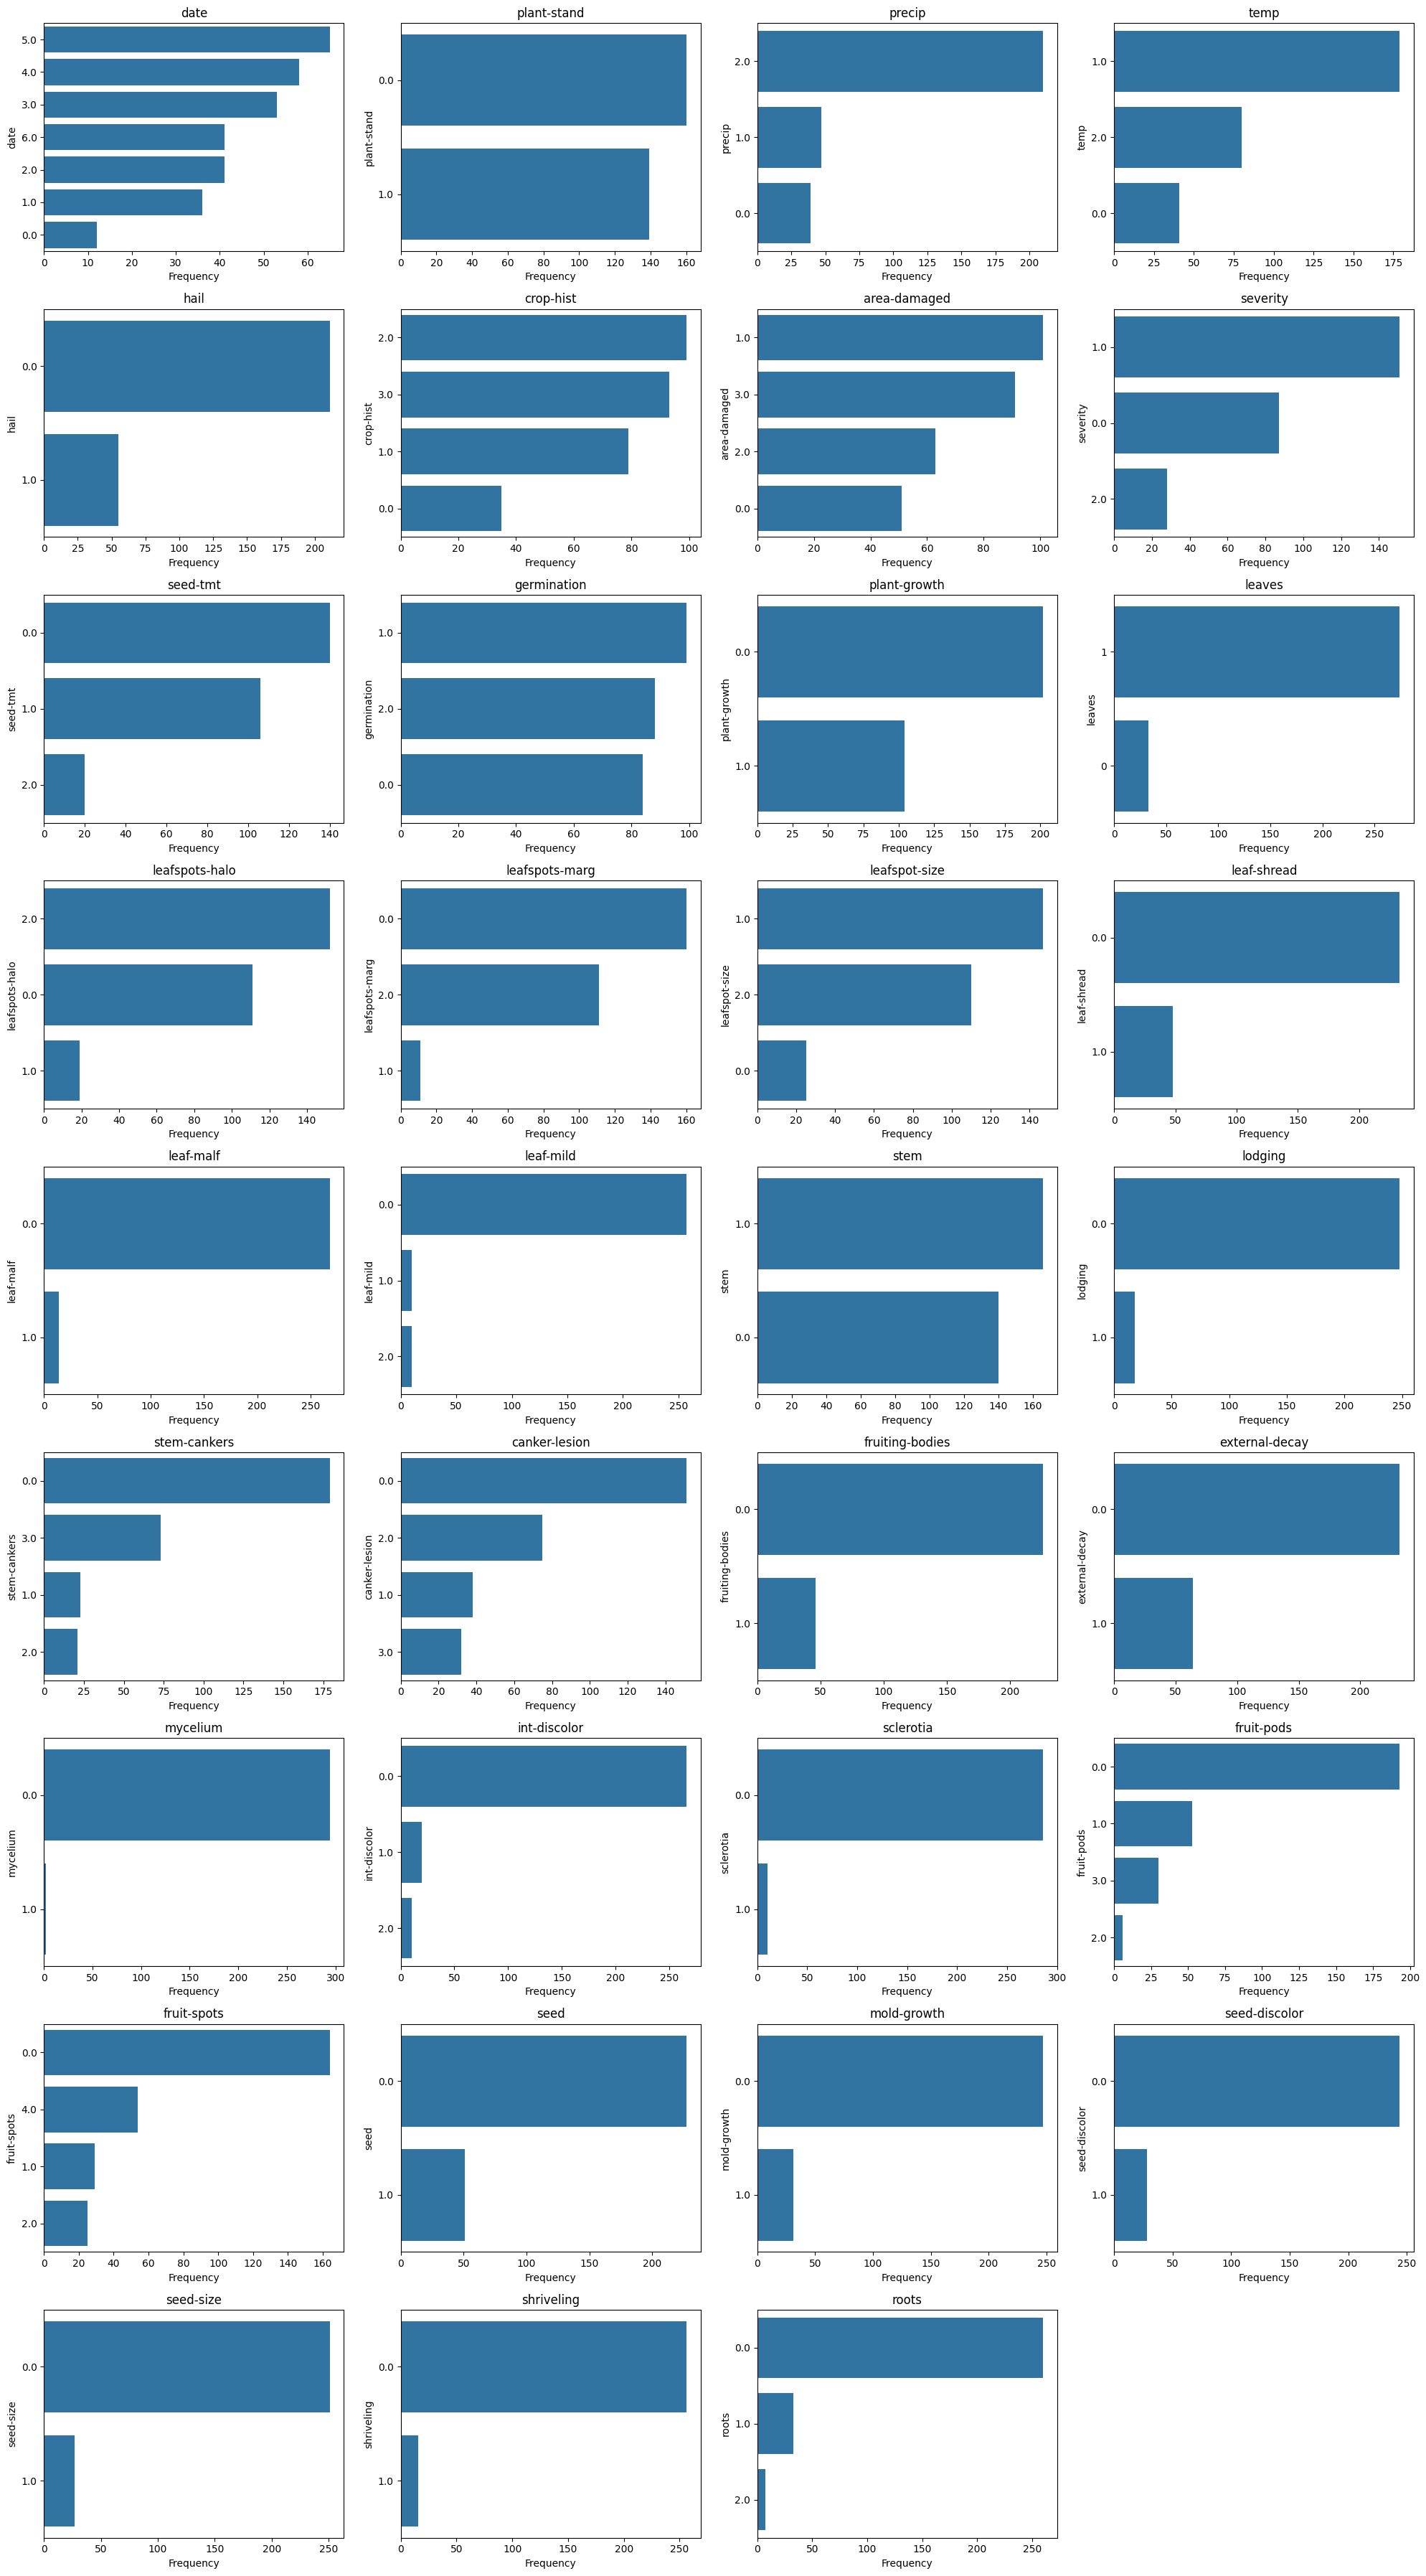

In [5]:
num_cols = 4
num_rows = math.ceil(len(X.columns) / num_cols)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 4))
axes = axes.flatten()
for i, col in enumerate(X.columns):
    sns.countplot(y=X[col], order=X[col].value_counts().index, ax=axes[i], hue=None, legend=False)
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel('Frequency')


for j in range(i + 1, num_rows * num_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### B. Investing missing 18% of data

Are there particular predictors that are more likely to be missing? Is the pattern of missing data related to  the classes?  

Answer: to answer this question, I made two charts, both normalized as % missing:
* A basic bar chart showing the distribution of missing data across the entire datset, normalized as percent missing
* A heatmap showing % missing by predictor class

It seems like the highest clustering is around some sort of damage to the seeds themselves, which could mean it's harder data to collect and organize effectively relative to others:
 * germination
 * fruit-spots
 * seed-discolor


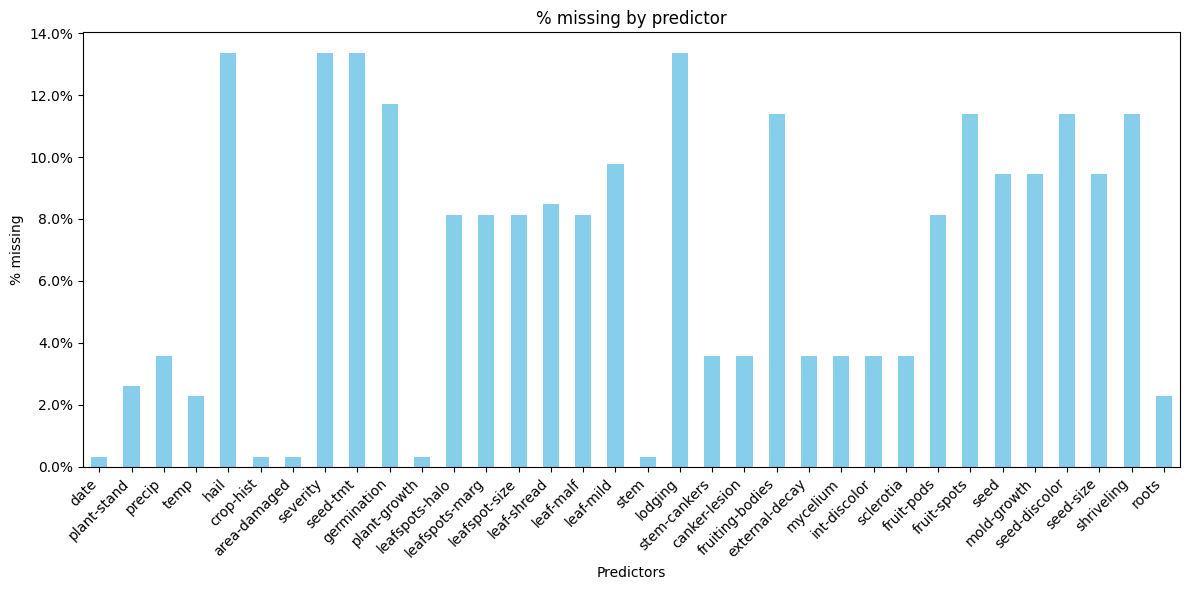

In [6]:

soybean_large = fetch_ucirepo(id=90) 
X = soybean_large.data.features 
y = soybean_large.data.targets 

missing_data = X.isnull().mean() * 100
md_filtered = missing_data[missing_data > 0]

plt.figure(figsize=(12, 6))
md_filtered.plot(kind='bar', color='skyblue')
plt.xlabel('Predictors')
plt.ylabel('% missing')
plt.title('% missing by predictor')
plt.xticks(rotation=45, ha='right')

plt.gca().yaxis.set_major_formatter(PercentFormatter())
plt.tight_layout()
plt.show()


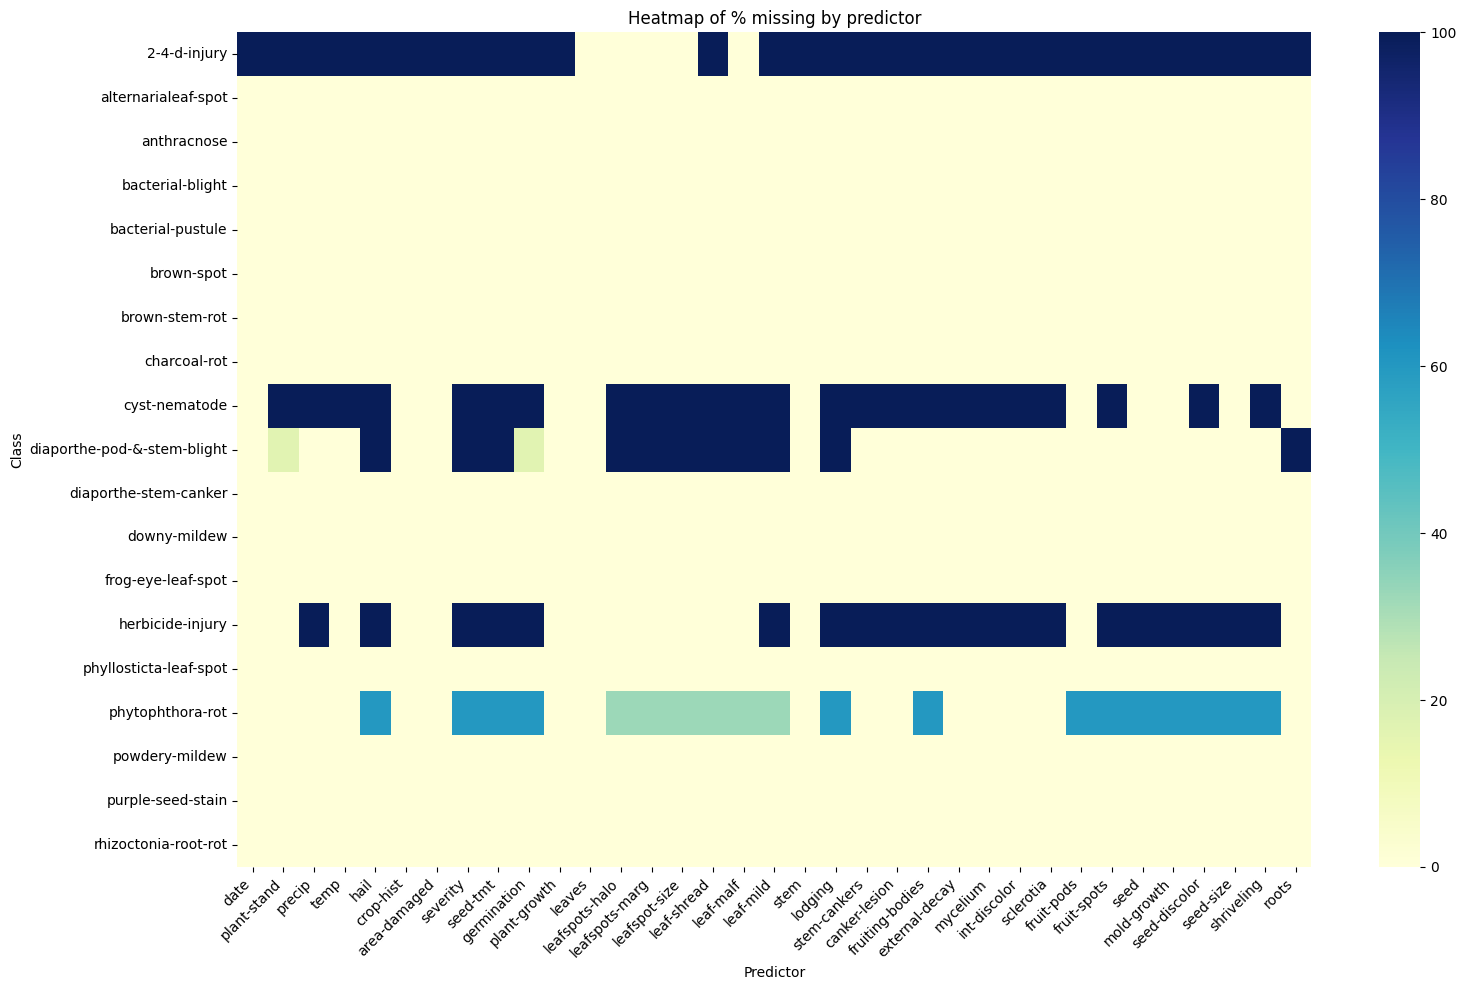

In [7]:
y = y.squeeze()  
missing_by_class = X.isnull().groupby(y).mean() * 100 

plt.figure(figsize=(16, 10))
sns.heatmap(missing_by_class, cmap='YlGnBu', annot=False, fmt=".1f")
plt.title('Heatmap of % missing by predictor')
plt.ylabel('Class')
plt.xlabel('Predictor')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### C. Strategy for handling missing data

Answer: I'm going to use a simple imputation strategy where the most frequent value is put in place of the missing values. I could do by median or mean as well but I was curious to see what this would do. This change is represented as before and after heatmaps below, showing the missing values being replaced.


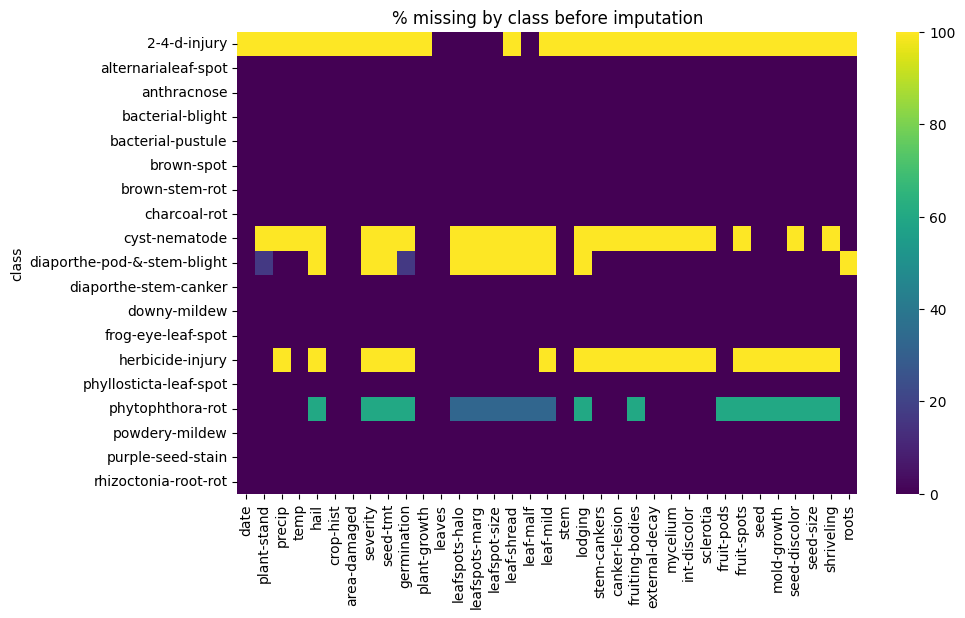

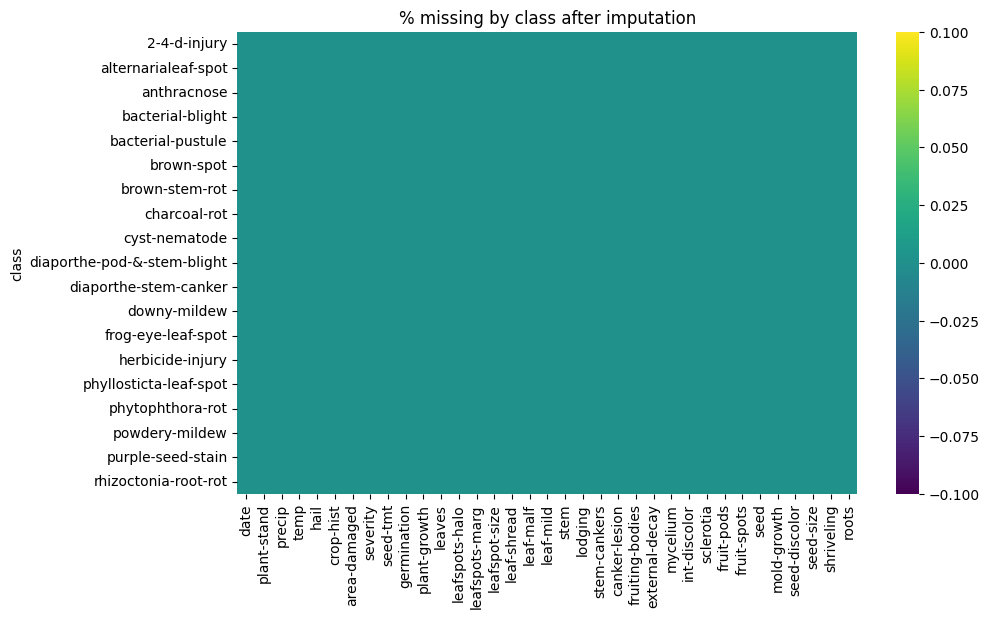

In [8]:
imputer = SimpleImputer(strategy='most_frequent')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
y = y.squeeze()

missing_before = X.isnull().groupby(y).mean() * 100
plt.figure(figsize=(10, 6))
sns.heatmap(missing_before, annot=False, cmap='viridis', cbar=True)
plt.title('% missing by class before imputation')
plt.show()


missing_after = X_imputed.isnull().groupby(y).mean() * 100
plt.figure(figsize=(10, 6))
sns.heatmap(missing_after, annot=False, cmap='viridis', cbar=True)
plt.title('% missing by class after imputation')
plt.show()
